# HMCTuning

Author: <b>Ignacio Peis</b>


In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import *
from examples import *


/Users/ipeis/opt/anaconda3/envs/HMCTuning/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This notebook is a simple guide on the usage of this package. Firstly, you will learn how to sample from any given unnormalized distribution. Secondly, you can tune the hyperparameters for obtaining better samples. Finally, several examples are provided to demonstrate the effectivity of tuning HMC.

# Sampling

Firstly, we need a function to return the objective, $\log p(\boldsymbol{x})$. This could even be an unnormalized distribution, given by any $f(\boldsymbol{x})$.

In [2]:
# Load the log probability function of MoG, and the initial proposal
logp = get_logp('wave')
mu0_pre, var0_pre = initial_proposal('wave')   # [0, 0],  [0.01, 0.01]


You can see here how the distribution looks like (blue surface). The Gaussian initial proposal is also plotted (contour).

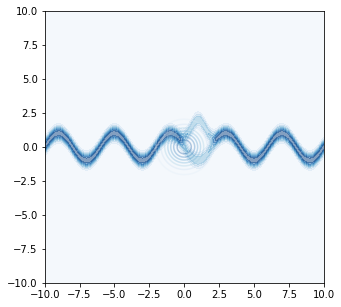

In [3]:
f, ax = plt.subplots(figsize=(5, 5))
plot_density('wave', ax)

xmin, xmax, ymin, ymax = get_grid_lims('wave')   
x1grid = np.linspace(xmin, xmax, 1000)
x2grid = np.linspace(ymin, ymax, 1000)
plot_bi_gaussian(mu0_pre, var0_pre, x1grid, x2grid, ax)

Firstly, the HMC is initialized using:

In [4]:
# Create the HMC object
hmc = HMC(dim=2, logp=logp, T=5,  L=5, chains=100, chains_sksd=30, mu0=mu0_pre, var0=var0_pre, vector_scale=True)

To obtain 1000 samples from the HMC object, just run:

(-10.0, 10.0)

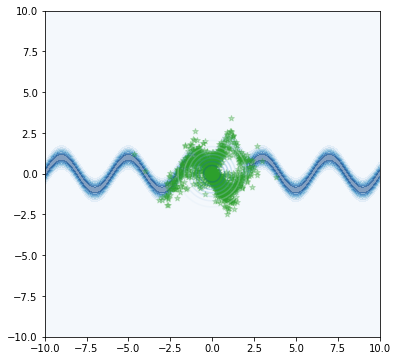

In [5]:
samples_pre, chains = hmc.sample(chains=1000)

# Numpy samples for plotting with maplotlib
samples_pre = samples_pre.detach().numpy()

f, ax = plt.subplots(figsize=(6, 6))
plot_density('wave', ax)
ax.scatter(samples_pre[0, :, 0], samples_pre[0, :, 1], marker='*', color='tab:green', alpha=0.3)

plot_bi_gaussian(mu0_pre, var0_pre, x1grid, x2grid, ax)
ax.set_xlim(xmin, xmax) 
ax.set_ylim(ymin, ymax) 



# Training
As you might observe, provided that the proposal is tight, the chains get stuck in a small region. To fit the hyperparameters:

In [6]:
hmc.fit(steps=100)

HMC (objective=-0.465884): 100%|██████████| 100/100 [00:08<00:00, 11.66it/s] 


Let's now observe how sampling from the wave density changed after training:

Text(0.5, 1.0, 'After training')

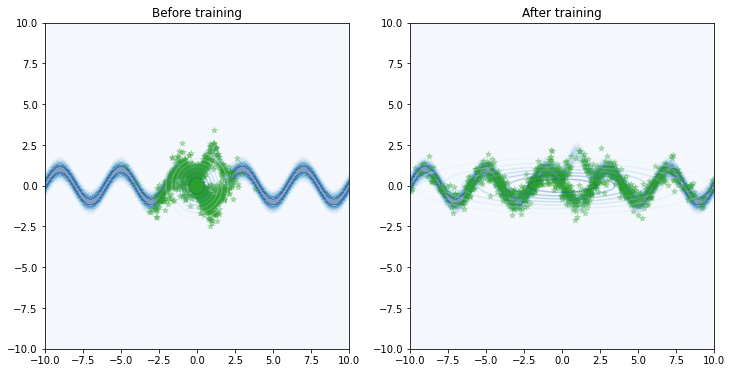

In [7]:
samples, chains = hmc.sample(chains=1000)

# Numpy samples for plotting with maplotlib
samples = samples.detach().numpy()

f, ax = plt.subplots(1, 2, figsize=(12, 6))
[plot_density('wave', axis) for axis in ax]

ax[0].scatter(samples_pre[0, :, 0], samples_pre[0, :, 1], marker='*', color='tab:green', alpha=0.3)
ax[1].scatter(samples[0, :, 0], samples[0, :, 1], marker='*', color='tab:green', alpha=0.3)

mu0 = hmc.mu0.detach().numpy()
var0 = torch.exp(hmc.logvar0) * torch.exp(2*hmc.log_inflation)
var0 = var0.detach().numpy()

plot_bi_gaussian(mu0_pre, var0_pre, x1grid, x2grid, ax[0])
plot_bi_gaussian(mu0, var0, x1grid, x2grid, ax[1])

[axis.set_xlim(xmin, xmax) for axis in ax]
[axis.set_ylim(ymin, ymax) for axis in ax]

ax[0].set_title('Before training')
ax[1].set_title('After training')


You can check how the objectives were optimized during training.

Text(0.5, 0, 'step')

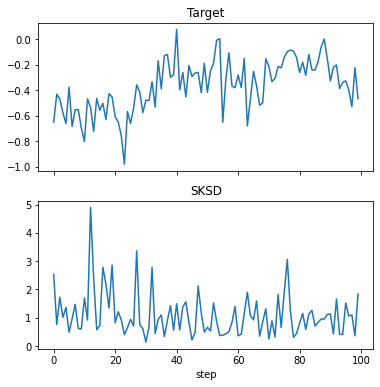

In [8]:
f, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

ax[0].plot(hmc.objective)
ax[0].set_title('Target')
ax[1].plot(hmc.sksd)
ax[1].set_title('SKSD')
plt.xlabel('step')


## Another example
Let's check another interesting example: a dual moon distribution. If we use a zero-centered Gaussian proposal, and small chains of $T=5$, they will get stuck before reaching the density:

(-3.0, 3.0)

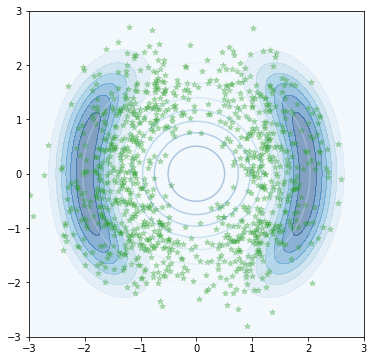

In [9]:
logp = get_logp('dual_moon')
mu0_pre, var0_pre = initial_proposal('dual_moon')
hmc = HMC(dim=2, logp=logp, T=5, mu0=mu0_pre, var0=var0_pre)
samples_pre, _ = hmc.sample(chains=1000)

samples_pre = samples_pre.detach().numpy()
f, ax = plt.subplots(figsize=(6, 6))
plot_density('dual_moon', ax)
ax.scatter(samples_pre[0, :, 0], samples_pre[0, :, 1], marker='*', color='tab:green', alpha=0.3)

xmin, xmax, ymin, ymax = get_grid_lims('dual_moon')
plot_bi_gaussian(mu0_pre, var0_pre, x1grid, x2grid, ax)
ax.set_xlim(xmin, xmax) 
ax.set_ylim(ymin, ymax) 

If we increase the length: 

[(-3.0, 3.0), (-3.0, 3.0), (-3.0, 3.0)]

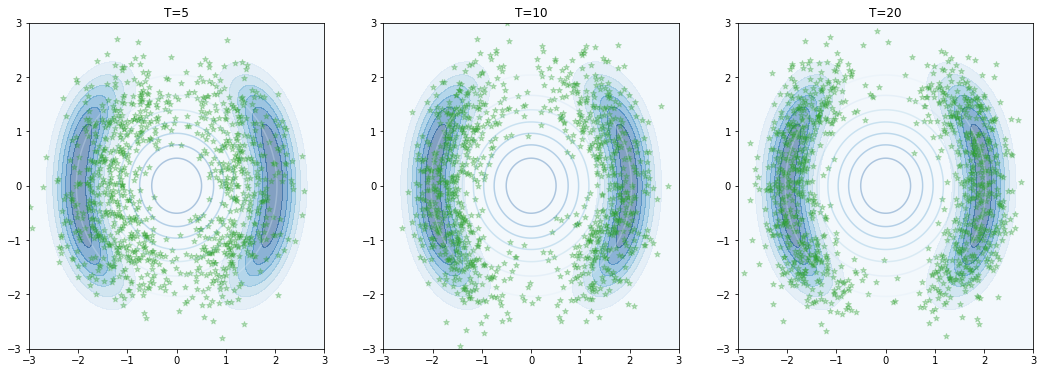

In [10]:

hmc = HMC(dim=2, logp=logp, T=10, mu0=mu0_pre, var0=var0_pre)
samples_T10, _ = hmc.sample(chains=1000)


hmc = HMC(dim=2, logp=logp, T=20, mu0=mu0_pre, var0=var0_pre)
samples_T20, _ = hmc.sample(chains=1000)


samples_T10 = samples_T10.detach().numpy()
samples_T20 = samples_T20.detach().numpy()

f, ax = plt.subplots(1, 3, figsize=(18, 6))
[plot_density('dual_moon', axis) for axis in ax]
ax[0].scatter(samples_pre[0, :, 0], samples_pre[0, :, 1], marker='*', color='tab:green', alpha=0.3)
ax[0].set_title('T=5')
ax[1].scatter(samples_T10[0, :, 0], samples_T10[0, :, 1], marker='*', color='tab:green', alpha=0.3)
ax[1].set_title('T=10')
ax[2].scatter(samples_T20[0, :, 0], samples_T20[0, :, 1], marker='*', color='tab:green', alpha=0.3)
ax[2].set_title('T=20')

[plot_bi_gaussian(mu0_pre, var0_pre, x1grid, x2grid, axis) for axis in ax]
[axis.set_xlim(xmin, xmax) for axis in ax]
[axis.set_ylim(ymin, ymax) for axis in ax]

As it can be observed, for $T=5$, chains get stuck. For chains of $T=10$, samples improve but not enough. For chains of $T=20$, the density is better explored. But as you might know, increasing the length is computationally expensive. What if we tune the hyperparameters for $T=10$?

HMC (objective=-0.70314): 100%|██████████| 200/200 [00:33<00:00,  5.95it/s] 


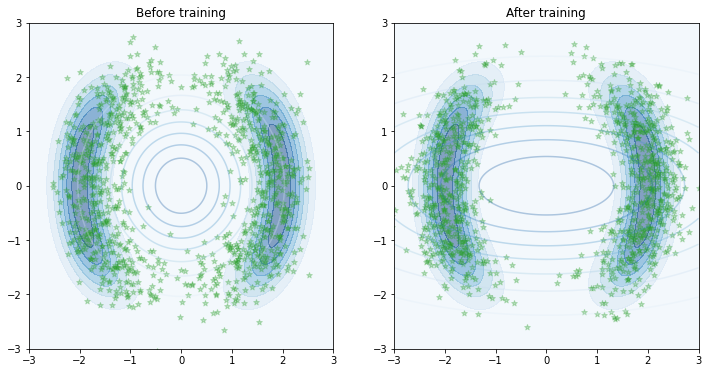

In [11]:
pre_post_training('dual_moon', T=10, steps=200, vector_scale=True)


Thanks to training the hyperparameters, we obtain efficient samples that correctly explore the density without adding extra cost.